# Single Shot Detector model implemented in Keras for traffic sign detection
In notebook below is my solution of traffic signs detection for my master thesis of self-driving car. As detector-model was choosen SSD7(Single Shot Detection model with 7 layers) model which was implemented using Keras machine learning library. As primary sourse i used [SSD: Single-Shot MultiBox Detector implementation in Keras](https://github.com/pierluigiferrari/ssd_keras#ssd-single-shot-multibox-detector-implementation-in-keras)

In code part below is all dependencies which is mandatory for stable workflow

In [ ]:
%tensorflow_version 1.x #set tensorflow 1.x version for google colab, it required by model
from google.colab import drive
import os, sys
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Colab_Notebooks/Traffic_sign_detection'
sys.path.insert(0, path)

TensorFlow 1.x selected.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from keras.optimizers import Adam, SGD, Adagrad
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

import cv2
import os
import xml.etree.ElementTree as ET
import csv
from random import random, shuffle

%matplotlib inline

Using TensorFlow backend.


In [ ]:
img_height = 300 # Height of the input images
img_width = 400 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = None # Set this to your preference (maybe `None`).
                      # The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = None # Set this to your preference (maybe `None`). 
                       # The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors.
                                        #If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

In [ ]:
# 1: Build the Keras model
K.clear_session() # Clear previous models from memory.
model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range,
                    top_k=20,
                    nms_max_output_size=50)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 400, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 400, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 300, 400, 32) 2432        identity_layer[0][0]             
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 300, 400, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

# Data preparation part
This part contain steps for data preparation
Code section below contain algorhitm for converting labeled .xml files into .csv file with all labeled data and it includes 6 columns for each row with follow structure
frameName.png,xmin,xmax,ymin,ymax,class_id

Dataset contains collected images by 5 classes, espessially: traffic light red, traffic light green, stop sign, crosswalk and priority road signs

In [ ]:
annotations_path = '/dataset/annotations/' # annotations folder contains .xml files with labeled classes
images_dir = '/dataset/images/'  # annotations folder contains .png files with images

files = [file for _, _ , file in os.walk(images_dir)][0]
print(f'Count of files: {len(files)}')
images_names = [i[0:-4] +'.png' for i in files]
files = [i[0:-4] +'.xml' for i in files]

shuffle(files)
#______________________________________________
# frame,xmin,xmax,ymin,ymax,class_id
# 1478019952686311006.jpg,237,251,143,155,1
#______________________________________________
classes_dict = {'background': 0,'trafficlight_red': 1, 'stop': 2, 'trafficlight_green': 3, 'crosswalk': 4, 'priority_road':5}
classes_name = ['background', 'trafficlight_red', 'stop', 'trafficlight_green', 'crosswalk', 'priority_road']
inappropriate_img = []
images_with_boxes = []
classes_ids = [] 
for file in files:
    filename = images_dir + file[0:-4]+'.png'
    if cv2.imread(filename, cv2.IMREAD_GRAYSCALE).shape == (300, 400):
        root = ET.parse(annotations_path+file).getroot()
        for type_tag in root.findall('object'):
            class_id = classes_dict[type_tag.find('name').text]
            xmin = type_tag.find('bndbox')[0].text
            ymin = type_tag.find('bndbox')[1].text
            xmax = type_tag.find('bndbox')[2].text
            ymax = type_tag.find('bndbox')[3].text
            images_with_boxes.append((file[0:-4]+'.png',xmin,xmax,ymin,ymax,class_id))
            classes_ids.append(class_id)
    else:
        inappropriate_img.append(file[0:-4]+'.png')

train_part = 0.97
train_images = images_with_boxes[0:int(len(images_names)*train_part)]

first_row = ('frame','xmin','xmax','ymin','ymax','class_id')
train_images.insert(0, first_row)
with open('/dataset/labels_train.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerows(train_images)
    file.close()

test_images = images_with_boxes[int(len(images_names)*train_part):len(images_names)]
test_images.insert(0, first_row)
with open('/dataset/labels_test.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerows(test_images)
    file.close()

print(f"Number of train samples: {len(train_images)}, number of test samples: {len(test_images)}")
[print(f'Count items of Class "{k}" is -> {classes_ids.count(v)}') for k,v  in classes_dict.items()]

Count of files: 501
Number of train samples: 486, number of test samples: 17
Count items of Class "background" is -> 0
Count items of Class "trafficlight_red" is -> 349
Count items of Class "stop" is -> 161
Count items of Class "trafficlight_green" is -> 308
Count items of Class "crosswalk" is -> 142
Count items of Class "priority_road" is -> 105


[None, None, None, None, None, None]

In [ ]:
# train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
# test_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)


In [ ]:
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
test_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

#____________________________________________________________________________________________________
# csv example
# frame,xmin,xmax,ymin,ymax,class_id
# 1478019952686311006.jpg,237,251,143,155,1
# 1478019952686311006.jpg,437,454,120,186,3
absolute_path = '/dataset/'
images_dir = absolute_path+'images/'
annotations_path = absolute_path + 'annotations/'

train_labels_filename = absolute_path +'labels_train.csv'
test_labels_filename   = absolute_path +'labels_test.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all', )

test_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=test_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')


train_dataset.create_hdf5_dataset(file_path='dataset_traffic_train.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

test_dataset.create_hdf5_dataset(file_path='dataset_traffic_test.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
test_dataset_size   = test_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(test_dataset_size))

Creating HDF5 dataset:  30%|██▉       | 65/219 [00:00<00:01, 118.96it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Creating HDF5 dataset: 100%|██████████| 12/12 [00:00<00:00, 103.21it/s]
Number of images in the training dataset:	   219
Number of images in the validation dataset:	    12


In [ ]:
# 3: Set the batch size.

batch_size = 16

# 4: Define the image processing chain.

data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = test_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

In [ ]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.

model_checkpoint = ModelCheckpoint(filepath='final_model/ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=2,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='final_model/ssd7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=2)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.0001)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [ ]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 50 
steps_per_epoch = 100

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(test_dataset_size/batch_size),
                              initial_epoch=initial_epoch,
                              )


Epoch 1/50
100/100 [==============================] - 34s 336ms/step - loss: 8.8126 - val_loss: 8.9547

Epoch 00001: val_loss improved from inf to 8.95472, saving model to /content/drive/MyDrive/Colab_Notebooks/Traffic_sign_detection/final_model/ssd7_epoch-01_loss-8.8409_val_loss-8.9547.h5
Epoch 2/50
100/100 [==============================] - 27s 266ms/step - loss: 4.8087 - val_loss: 4.8075

Epoch 00002: val_loss improved from 8.95472 to 4.80753, saving model to /content/drive/MyDrive/Colab_Notebooks/Traffic_sign_detection/final_model/ssd7_epoch-02_loss-4.8149_val_loss-4.8075.h5
Epoch 3/50
100/100 [==============================] - 30s 296ms/step - loss: 3.9907 - val_loss: 3.5091

Epoch 00003: val_loss improved from 4.80753 to 3.50909, saving model to /content/drive/MyDrive/Colab_Notebooks/Traffic_sign_detection/final_model/ssd7_epoch-03_loss-3.9989_val_loss-3.5091.h5
Epoch 4/50
100/100 [==============================] - 29s 291ms/step - loss: 3.5985 - val_loss: 3.0354

Epoch 00004: v

Let's look at how the training and validation loss evolved to check whether our training is going in the right direction:

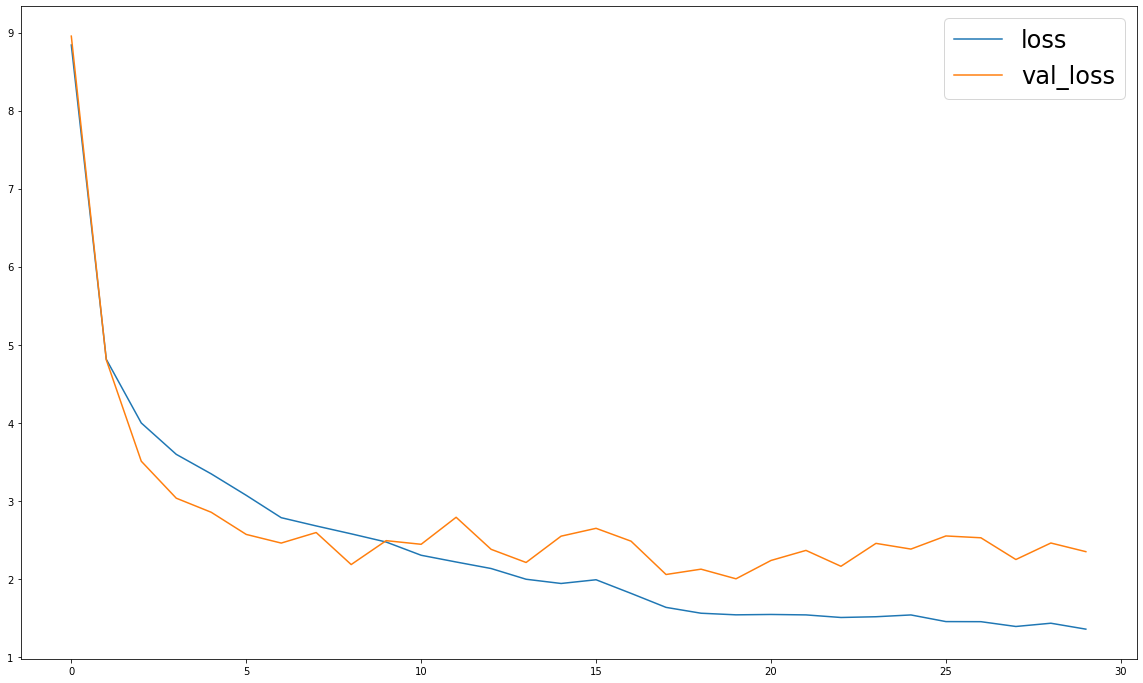

In [ ]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

Below is represented IOU (Intersection over Union) calculation function

In [ ]:
def get_iou(a, b, epsilon=1e-5):
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return round(iou,2)

In [ ]:
# 1: Set the generator for the predictions.

predict_generator = test_dataset.generate(batch_size=17,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

Beneath is model testing on evaluation part of dataset Trurth boxes is highlited by green, predicted boxes is colored by another color and also above of predicted box is label with predicted class confidence of prediction and calculated IOU (Intersection over Union)

Image: /content/drive/MyDrive/Colab_Notebooks/Traffic_sign_detection/dataset/images/road323.png shape (12, 300, 400, 3)

Ground truth boxes:

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  4.     1.   111.85  61.35 251.97 206.51]] [[  4 113  69 260 202]]


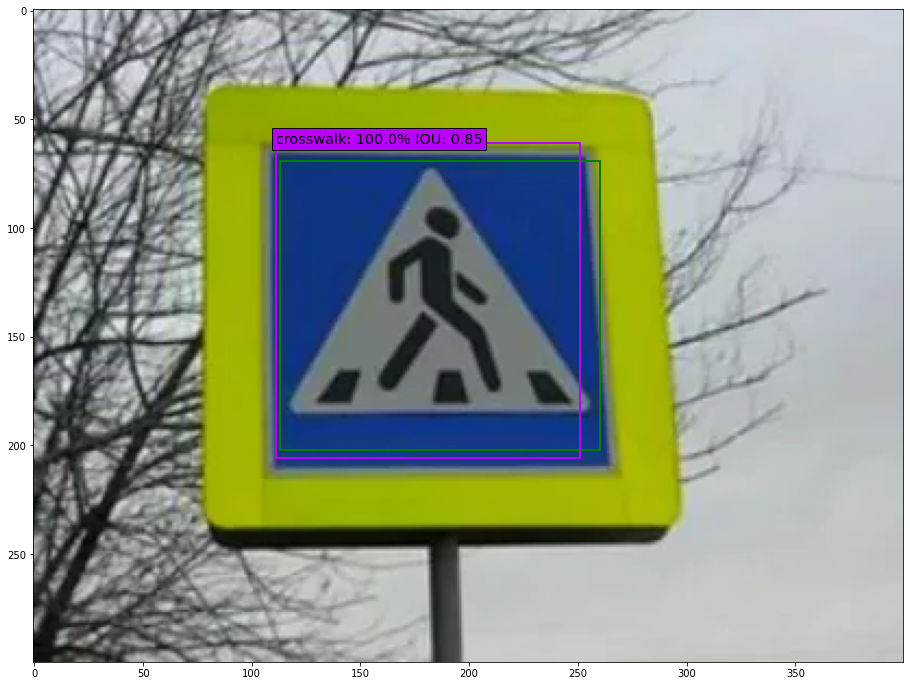

In [ ]:
# 5: Draw the predicted boxes onto the image

batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 2 # Which batch item to look at

print("Image:", batch_filenames[i], f"shape {batch_images.shape}")
print()
print("Ground truth boxes:\n")

y_pred = model.predict(batch_images)

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.2,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i],batch_labels[i])

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = classes_name# Just so we can print class names onto the image instead of IDs

for box1, box2 in zip(y_pred_decoded[i], batch_labels[i]):
    xmin1 = int(box1[-4])
    ymin1 = int(box1[-3])
    xmax1 = int(box1[-2])
    ymax1 = int(box1[-1])

    xmin2 = int(box2[1])
    ymin2 = int(box2[2])
    xmax2 = int(box2[3])
    ymax2 = int(box2[4])
    iou = get_iou([xmin1, ymin1, xmax1, ymax1], [xmin2, ymin2, xmax2, ymax2])
    current_axis.add_patch(plt.Rectangle((xmin2, ymin2), xmax2-xmin2, ymax2-ymin2, color='green', fill=False, linewidth=2))  

    color = colors[int(box1[0])]
    label = f'{classes[int(box1[0])]}: {round(box1[1]*100,1)}% IOU: {iou}'
    current_axis.add_patch(plt.Rectangle((xmin1, ymin1), xmax1-xmin1, ymax1-ymin1, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin1, ymin1, label, size='x-large', color='#000000', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
# model.save('SSD_model_.hdf5')
model.save('SSD_model.h5')